In [1]:
import pandas as pd 
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import copy

# Homogenous case : 
p and alpha are the same for each players

In [46]:
class Individual:
    def __init__(self, initialWealth, riskCurve, alpha,index,behaviour):
        self.initialWealth = initialWealth #wealth
        self.wealth = initialWealth
        self.riskCurve = riskCurve 
        self.alpha = alpha #fraction lost during bad event
        self.behaviour = behaviour #Initialized randomly when a simulation is launched
        self.contribution = []
        self.finalWealthHistory = []#Wealth at the end of each game 
        self.index = index
        self.fitness = None
        
    def __repr__(self):
        #To output a string representaion of the object
        return ('Individual {}, behaviour : {}'.format(self.index,str(self.behaviour)))

 
    def generateRandomBehaviour(self,numberOfRounds):
        #instanciate a random behaviour
        self.behaviour = [[round(random.random(),2),round(random.random(),2),round(random.random(),2)] for i in range(numberOfRounds)]
        #self.behaviour = [[round(random.random(),2),i/numberOfRounds,i/numberOfRounds] for i in range(numberOfRounds)]
    def setBehaviour(self,behaviour):
        self.behaviour = behaviour
        
    def setFitnessValue(self):
        #to calculate the fitness value a the end of a generation (usefull to render new population)
        self.fitness =  np.exp(np.mean(self.finalWealthHistory))
        
    def Contribution(self, Cr,nround):
        beh= self.behaviour[nround]
        if(Cr<=beh[0]):
            return beh[1]
        else:
            return beh[2]
        
    
    def Step(self, Cr ,nround):
        #amount contributed to public good
        c = self.Contribution(Cr,nround)
        contribution = c*self.wealth
        #calculate what's left of wealth
        return contribution
    
    def addFinalWealthToHistory(self):
        #to add the ramaining wealth at the end of a game, the the mean is done to calculate the fitness at the end of a generation
        self.finalWealthHistory.append(self.wealth)
        
    def setWealth(self,newWealth):
        self.wealth = newWealth
        
    def resetRound(self):
        self.wealth = self.initialWealth
        
def addNoiseToTreshold(behav,sigma):
    #add noise to the treshold in the wrightFisher process
    for elem in behav:
        elem[0] += round(np.random.normal(0,sigma),2)
        elem[0] = max(0,elem[0])
        elem[0] = min(1,elem[0])



        
def risk(Cr,riskCurve,InitialWealth,lambda1,lambda2,lambda3):#chance of having bad event happening
    
    p1 = lambda Cr :1 -(lambda1*Cr/InitialWealth)
    p2 = lambda Cr: 1-10*Cr if Cr<0.1 else 0
    p3 = lambda Cr : 1-math.pow(Cr/InitialWealth,lambda2)
    p4 = lambda Cr: 1/(math.exp(lambda3*((Cr/InitialWealth)-0.5))+1)
    dic = {'linear':p1,'piecewiseLinear':p2,'powerlaw':p3,'treshold':p4}
    if (random.random() < dic[riskCurve](Cr)):
        return 1
    return 0


In [3]:
a = 0
b = 0
c = 0
d = 0
for i in range(100):
    a += risk(0.6,'piecewiseLinear')
for i in range(100):
    b+= risk(0.6,'linear')
for i in range(100):
    c+= risk(0.6,'powerlaw')
for i in range(100):
    d+= risk(0.6,'treshold')
print(a)
print(b)
print(c)
print(d)



0
37
87
23


In [53]:
class Simulation:
    def __init__(self,numberOfRounds,alpha,riskCurve,wealth = 1,populationSize=100,numberOfGamesByGenerations=1000,numberOfGenerations=10000,mu=0.03,sigma=0.15,catastrophicEventSchedule = 'Every Rounds',displayContribution='Total'):
        #number of round : omega in the paper
        self.numberOfRounds = numberOfRounds
        self.numberOfGamesByGenerations = numberOfGamesByGenerations
        self.numberOfGenerations = numberOfGenerations
        self.wealth = wealth 
        self.alpha = alpha
        self.riskCurve = riskCurve
        self.populationSize = populationSize
        #create the first population
        self.population = self.createRandomPopulation()
        self.mu = mu
        self.sigma = sigma
        #schedule of the catastrophic event (last round, first round, every round or final round)
        self.catastrophicEventSchedule = catastrophicEventSchedule
        #set the schedule ie the round in wich player will loose wealth
        self.schedule = self.setEventSchedule()
         #display of the contribution : total if we want the mean of cooperation for every round, Every round if we want the detail for each round
        self.displayContribution = displayContribution 
        self.lambda1 = 1
        self.lambda2 = 10
        self.lambda3 = 10
        
    def createRandomPopulation(self):
        #create the first population
        population = np.array([Individual(self.wealth,self.riskCurve,self.alpha,i,None) for i in range(self.populationSize)])
        for individual in population:
            #initialize the behaviour (lenght = numberofRounds)
            individual.generateRandomBehaviour(self.numberOfRounds)
        #set a null behaviour to help convergence
        population[0].setBehaviour([[round(random.random(),2),0,0] for i in range(self.numberOfRounds)])
        return population
    
    def setEventSchedule(self):
        #create the event schedule
        if self.catastrophicEventSchedule == 'Every Rounds':
            schedule = np.ones(self.numberOfRounds, dtype=bool)
        elif self.catastrophicEventSchedule == 'First Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            schedule[0] = True
            
        elif self.catastrophicEventSchedule == 'Last Round':
            self.schedule = np.zeros(self.numberOfRounds, dtype=bool)
            schedule[-1] = True
            
        elif self.catastrophicEventSchedule == 'Random Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            r = np.random.randint(self.numberOfRounds)
            schedule[r] = True
        else:
            raise ValueError('Incorrect shedule argument passed')
        return schedule
            
    
    def renewPopulation(self):
        """
        renew population in function of the fitness of each individual, individual with high fitness are more likely to pass
        to the next generation
        """
        fitness = np.array([individual.fitness for individual in self.population])
        fitprop = fitness/np.sum(fitness)
        numoffspring = np.random.multinomial(self.populationSize, fitprop)
        a = []
        for j in range(len(numoffspring)):
            for i in range(numoffspring[j]):
                b = [elem for elem in self.population[j].behaviour]
                #memory[counter+i] = b
                a.append(copy.deepcopy(b))
        return a
    

            
     
        
        
    
    def playGame(self,players):
        #play a game between two players (or more)
        Cr = 0 # initial public good 
        totalInitialWealth = np.sum([player.wealth for player in players])
        contributions=np.empty((len(players),self.numberOfRounds))
        for nround in range(self.numberOfRounds):
            #print('-----round ',nround)
            for i in range(len(players)):
                contributions[i,nround] = players[i].Step(Cr,nround)
            Cr += np.sum(contributions[:,nround])/totalInitialWealth
            
            if self.schedule[nround]:
                for i in range(len(players)):
                    newWealth = (1-self.alpha*risk(Cr,self.riskCurve,players[i].initialWealth,self.lambda1,self.lambda2,self.lambda3))*(players[i].wealth-contributions[i,nround])
                    players[i].setWealth(newWealth)
            
        for i in range(len(players)):
            players[i].contribution.append(contributions[i]/players[i].initialWealth)
                  
        for player in players:
            player.addFinalWealthToHistory()
            player.resetRound()
            
        
    
    def playGeneration(self):
        #for a certain number of iteration 2 players are selected randomly and the play a game
        for i in range(self.numberOfGamesByGenerations):
            players = np.random.choice(self.population,2,replace=False)
            self.playGame(players)

    def wrightFisher(self): 
        #renew the population and add noise
        #print('1---------',self.population)
        newBehaviours = self.renewPopulation()
        for behav in newBehaviours:
            a = np.random.rand()
            b = np.random.rand()
            if a<self.mu:
                for elem in behav:
                    elem[0] += round(np.random.normal(0,self.sigma),2)
                    elem[0] = max(0,elem[0])
                    elem[0] = min(1,elem[0])
            if b<self.mu:
                for elem in behav:
                    elem[1] = round(np.random.uniform(0,1),2)
                    elem[2] = round(np.random.uniform(0,1),2)
        self.population = [Individual(self.wealth,self.riskCurve,self.alpha,i,newBehaviours[i]) for i in range(self.populationSize)]
        #print('2---------',self.population)
        
    
    def runSim(self):
        #lauch a simulation 
        averageResults = []

        for i in range(self.numberOfGenerations):
            self.playGeneration()
            contributionValues = []
            for j in range(self.populationSize):
                self.population[j].setFitnessValue()
                if (self.displayContribution =='Total'):
                    TotalContribution = [np.sum(elem) for elem in self.population[j].contribution]
                    mean = np.mean(TotalContribution)
                    contributionValues.append(mean)
                elif (self.displayContribution =='Every Round'):
                    mean = np.mean(self.population[j].contribution,axis = 0)
                    contributionValues.append(mean)
                else:
                    raise ValueError('incorrect dispalyContribution argument passed') 
                    
            if (self.numberOfGenerations-50<=i<self.numberOfGenerations):
                averageResults.append(np.mean(contributionValues,axis = 0))
            self.wrightFisher() 
        av = np.mean(averageResults,axis=0)
        print('for omega = {},alpha = {}, riskurve : {}, c = {}'.format(self.numberOfRounds,self.alpha,self.riskCurve,av))
        return av

    

            
        
            
        
    

In [55]:
sim = Simulation(4,1,'linear',numberOfGenerations = 10,mu = 0.03,displayContribution = 'Every Round')
sim.runSim()

for omega = 4,alpha = 1, riskurve : linear, c = [ 0.60351     0.09536173  0.02952913  0.01195457]


array([ 0.60351   ,  0.09536173,  0.02952913,  0.01195457])

In [ ]:
alpha = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
riskCurve = ['piecewiseLinear','linear','treshold','powerlaw']
omega = [1,2,4]

In [100]:
results = np.zeros((len(omega),len(riskCurve),len(alpha)))
for o in omega:
    for r in riskCurve:
        for a in alpha:
            sim = Simulation(o,a,r,numberOfGenerations = 100)
            results[o,r,a] = sim.runSim() 
            
            

----------Generation 0
contribution : 0.5357
0.10314
----------Generation 0
contribution : 0.4597
0.230226
----------Generation 0
contribution : 0.4539
0.461492
----------Generation 0
contribution : 0.5138
0.61319


>>>>Round :  1 <<<<<
Wealth 0.81 contribution 0.1
Wealth 0.45 contribution 0.5
>>>>Cr :  0.6 
>>>>Round :  2 <<<<<
Wealth 0.2790000000000001 contribution 0.5
Wealth 0.225 contribution 0.2
>>>>Cr :  1.2999999999999998 


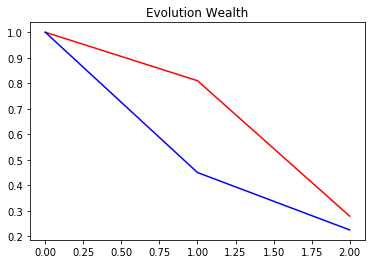

In [23]:
rounds = 2 # amount of rounds
Cr = 0 # initial public good 
population = CreatePopulation(2) # population of players
population[1].behaviour = [[0.1,0.5,0.1],[0.7,0.2,0.5]]
temp = 0
for p in population:
        temp += p.W
for p in population:
        p.total = temp*len(population)

for i in range(rounds):
    temp=0
    print(">>>>Round : ", i+1, "<<<<<")
    for p in population:
        temp += p.Step(Cr)
    Cr+=temp
    print(">>>>Cr : ", Cr, "")
    
    
plt.title('Evolution Wealth')
plt.plot(population[0].history,'r')
plt.plot(population[1].history,'b')
plt.show()

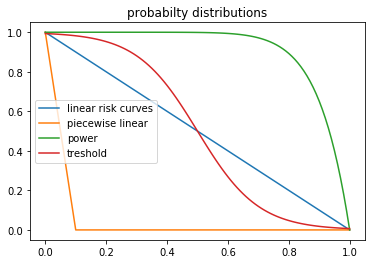

In [45]:
#Risk curves plotting
lambda1 = 1
InitialWealth = 1
lambda2 = 10
lambda3 = 10

p1 = lambda Cr :1 -(lambda1*Cr/InitialWealth)
p2 = lambda Cr: 1-10*Cr if Cr<0.1 else 0
p3 = lambda Cr : 1-math.pow(Cr/InitialWealth,lambda2)
p4 = lambda Cr: 1/(math.exp(lambda3*((Cr/InitialWealth)-0.5))+1)

xas = np.arange(0.0, 1.01, 0.01)
yas = [ p1(x) for x in xas ]
yas2 = [p2(x) for x in xas] 
yas3 = [p3(x) for x in xas] 
yas4 = [p4(x) for x in xas] 
plt.plot(xas, yas,label = 'linear risk curves')
plt.plot(xas, yas2,label='piecewise linear')
plt.plot(xas, yas3, label = 'power')
plt.plot(xas, yas4, label = 'treshold')
plt.legend()
plt.title('probabilty distributions')
plt.show()

In [137]:
plot1 =[]
plot1.append(1)


In [10]:
a = [10,0,10,0]
np.mean(a,axis=0)

5.0

In [9]:
a = 0
if a == 1:
    print('yo')
else:
    raise ValueError('batard')

ValueError: batard

# Non Homogeneous Case


In [41]:
class Simulation:
    def __init__(self,numberOfRounds,alpha,riskCurve,wealthPoor = 1,wealthRich = 4,populationSize=100,numberOfGamesByGenerations=1000,numberOfGenerations=10000,mu=0.03,sigma=0.15,catastrophicEventSchedule = 'Every Rounds',displayContribution='Total',fractionOfPoor = 0.5):
        self.numberOfRounds = numberOfRounds
        self.fractionOfPoor = fractionOfPoor
        self.numberOfGamesByGenerations = numberOfGamesByGenerations
        self.numberOfGenerations = numberOfGenerations
        self.wealthPoor = wealthPoor
        self.wealthRich = wealthPoor
        self.alpha = alpha
        self.riskCurve = riskCurve
        self.populationSize = populationSize
        #create the first population
        self.populationPoor, self.populationRich = self.createRandomPopulation()
        self.mu = mu
        self.sigma = sigma
        self.catastrophicEventSchedule = catastrophicEventSchedule
        self.schedule = self.setEventSchedule()
        self.displayContribution = displayContribution 
        
    def createRandomPopulation(self):
        #create the first population
        population = []
        for i in len(self.populationSize):
            if np.random.rand()<self.fractionOfPoor:
                ind = Individual(self.wealthPoor,self.riskCurve,self.alpha,i,None)
                ind.generateRandomBehaviour(self.numberOfRounds)
                populationPoor.append(ind)
            else:
                ind = Individual(self.wealthRich,self.riskCurve,self.alpha,i,None)
                ind.generateRandomBehaviour(self.numberOfRounds)
                populationRich.append(ind)
                
        populationPoor[0].setBehaviour([[round(random.random(),2),0,0] for i in range(self.numberOfRounds)])
        populationRich[0].setBehaviour([[round(random.random(),2),0,0] for i in range(self.numberOfRounds)])
        return populationPoor,populationRich
    
    def setEventSchedule(self):
        if self.catastrophicEventSchedule == 'Every Rounds':
            schedule = np.ones(self.numberOfRounds, dtype=bool)
        elif self.catastrophicEventSchedule == 'First Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            schedule[0] = True
            
        elif self.catastrophicEventSchedule == 'Last Round':
            self.schedule = np.zeros(self.numberOfRounds, dtype=bool)
            schedule[-1] = True
            
        elif self.catastrophicEventSchedule == 'Random Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            r = np.random.randint(self.numberOfRounds)
            schedule[r] = True
        else:
            raise ValueError('Incorrect shedule argument passed')
        return schedule
            
    
    def renewPopulation(self):
        fitness = np.array([individual.fitness for individual in self.population])
        fitprop = fitness/np.sum(fitness)
        numoffspring = np.random.multinomial(self.populationSize, fitprop)
        a = []
        for j in range(len(numoffspring)):
            for i in range(numoffspring[j]):
                b = [elem for elem in self.population[j].behaviour]
                #memory[counter+i] = b
                a.append(copy.deepcopy(b))
        return a
    

            
     
        
        
    
    def playGame(self,players):
        #play a game between two players (or more)
        Cr = 0 # initial public good 
        totalInitialWealth = np.sum([player.wealth for player in players])
        contributions=np.empty((len(players),self.numberOfRounds))
        for nround in range(self.numberOfRounds):
            #print('-----round ',nround)
            for i in range(len(players)):
                contributions[i,nround] = players[i].Step(Cr,nround)
            Cr += np.sum(contributions[:,nround])/totalInitialWealth
            if self.schedule[nround]:
                for i in range(len(players)):
                    newWealth = (1-self.alpha*risk(Cr,self.riskCurve))*(players[i].wealth-contributions[i,nround])
                    players[i].setWealth(newWealth)
            
        for i in range(len(players)):
            players[i].contribution.append(contributions[i]/players[i].initialWealth)
                  
        for player in players:
            player.addFinalWealthToHistory()
            player.resetRound()
            
        
    
    def playGeneration(self):
        #for a certain number of iteration 2 players are selected randomly and the play a game
        for i in range(self.numberOfGamesByGenerations):
            population = self.populationPoor + self.populationRich
            players = np.random.choice(population,2,replace=False)
            self.playGame(players)

    def wrightFisher(self): 
        #print('1---------',self.population)
        newBehaviours = self.renewPopulation()
        for behav in newBehaviours:
            a = np.random.rand()
            b = np.random.rand()
            if a<self.mu:
                for elem in behav:
                    elem[0] += round(np.random.normal(0,self.sigma),2)
                    elem[0] = max(0,elem[0])
                    elem[0] = min(1,elem[0])
            if b<self.mu:
                for elem in behav:
                    elem[1] = round(np.random.uniform(0,1),2)
                    elem[2] = round(np.random.uniform(0,1),2)
        self.population = [Individual(self.wealth,self.riskCurve,self.alpha,i,newBehaviours[i]) for i in range(self.populationSize)]
        #print('2---------',self.population)
        
    
    def runSim(self):
        averageResults = []
        #lauch a simulation 
        for i in range(self.numberOfGenerations):
            self.playGeneration()
            contributionValuesPoor = []
            contributionValuesRich = []
            for j in range(self.populationSize):
                self.populationPoor[j].setFitnessValue()
                if (self.displayContribution =='Total'):
                    TotalContribution = [np.sum(elem) for elem in self.population[j].contribution]
                    mean = np.mean(TotalContribution)
                    contributionValues.append(mean)
                elif (self.displayContribution =='Every Round'):
                    mean = np.mean(self.population[j].contribution,axis = 0)
                    contributionValues.append(mean)
                else:
                    raise ValueError('incorrect dispalyContribution argument passed') 
                    
            if (self.numberOfGenerations-50<=i<self.numberOfGenerations):
                averageResults.append(np.mean(contributionValues,axis = 0))
            self.wrightFisher() 
        av = np.mean(averageResults,axis=0)
        print('for omega = {},alpha = {}, riskurve : {}, c = {}'.format(self.numberOfRounds,self.alpha,self.riskCurve,av))
        return av

    

            

In [43]:
a = [1,2]
b=[1,2,3]
a+b

[1, 2, 1, 2, 3]